In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Normalization, Dense, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout, Embedding, Concatenate, BatchNormalization, UpSampling2D, Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
import os

In [2]:
imgs = pd.read_csv('../emnist-letters-train.csv', header=None)

imgs.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
imgs.shape

(99040, 785)

In [4]:
imgs_no_blank = imgs[imgs[0] != -1]

imgs_unlabeled = imgs_no_blank.iloc[:, 1:].values

labels = imgs_no_blank.iloc[:, 0].values

imgs_unlabeled.shape

(88800, 784)

In [5]:
num_imgs = imgs_unlabeled.shape[0]
img_size = int(np.sqrt(imgs_unlabeled.shape[1]))  # Assuming square images

In [6]:
imgs_final = imgs_unlabeled.reshape(num_imgs, img_size, img_size)

imgs_final = np.array([np.rot90(np.flipud(img), k=3) for img in imgs_final])

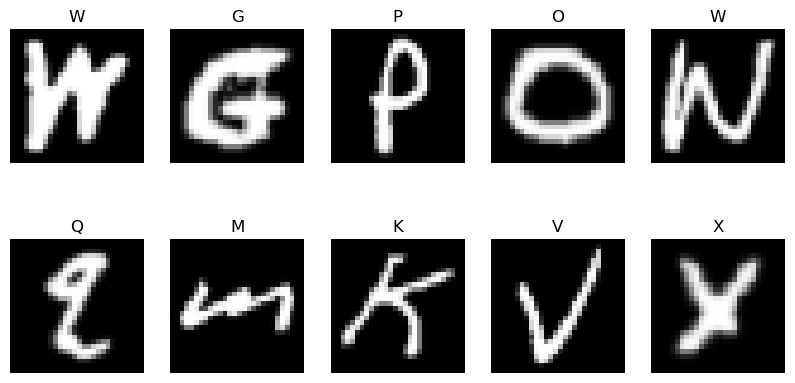

In [7]:
num_plot = 10
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i < num_plot:
        ax.imshow(imgs_final[i], cmap='gray')
        ax.set_title(chr(labels[i] + 64))
        ax.axis('off')

plt.show()

In [8]:
class_images = {}
for label in np.unique(labels):
    class_images[label] = imgs_final[labels == label]

num_classes = len(class_images)

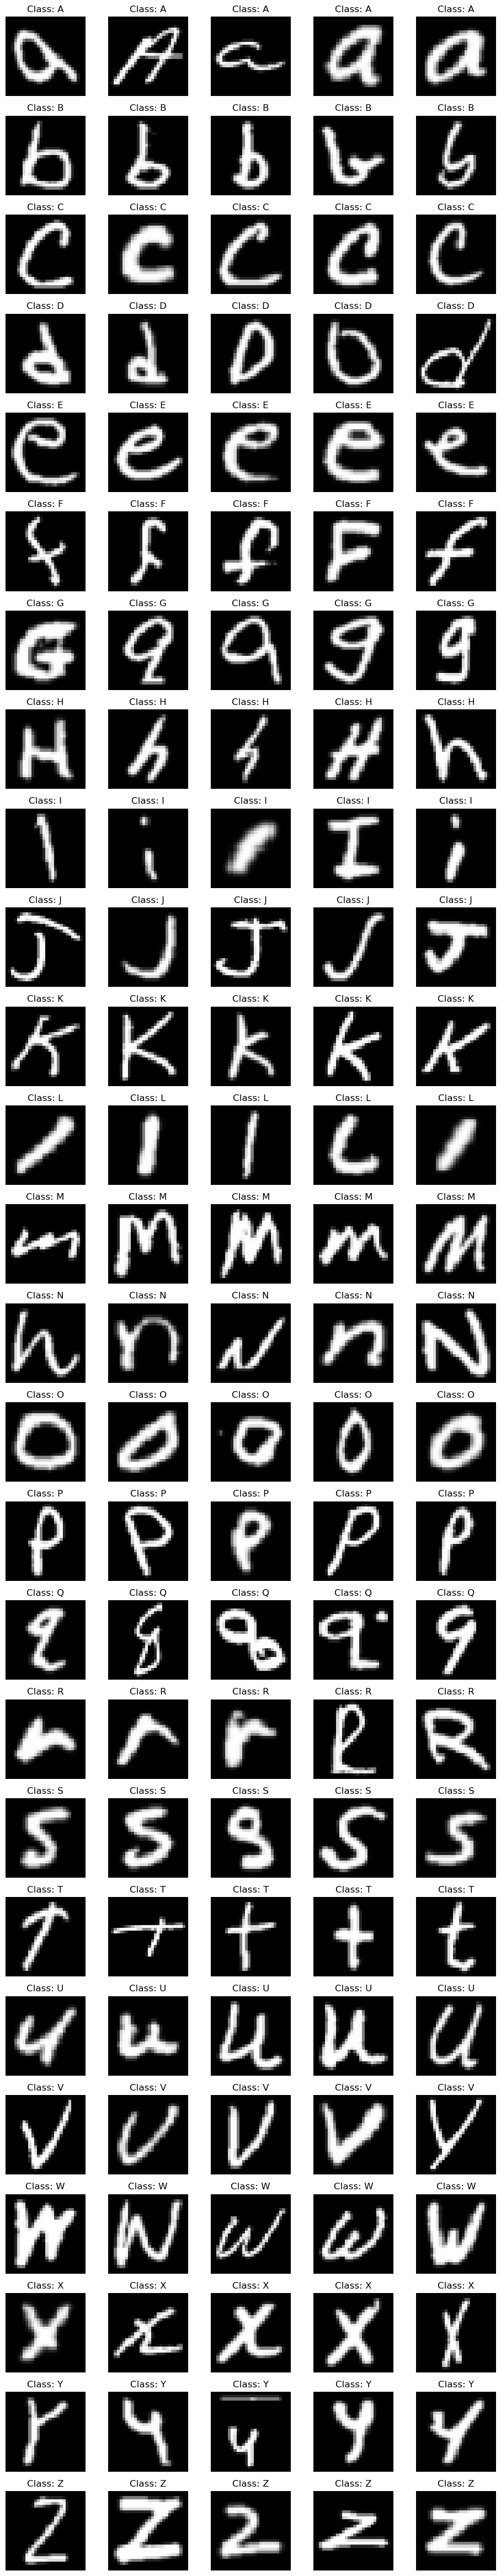

In [9]:
num_plot = 5

fig, axes = plt.subplots(num_classes, num_plot, figsize=(num_plot * 2, num_classes * 2))

for i, (label, imgs) in enumerate(class_images.items()):
    for j in range(num_plot):
        if j < len(imgs):
            axes[i, j].imshow(imgs[j], cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(f'Class: {chr(label + 64)}')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

In [10]:
labels = pd.Series(labels)
labels_counts = labels.value_counts().sort_index()

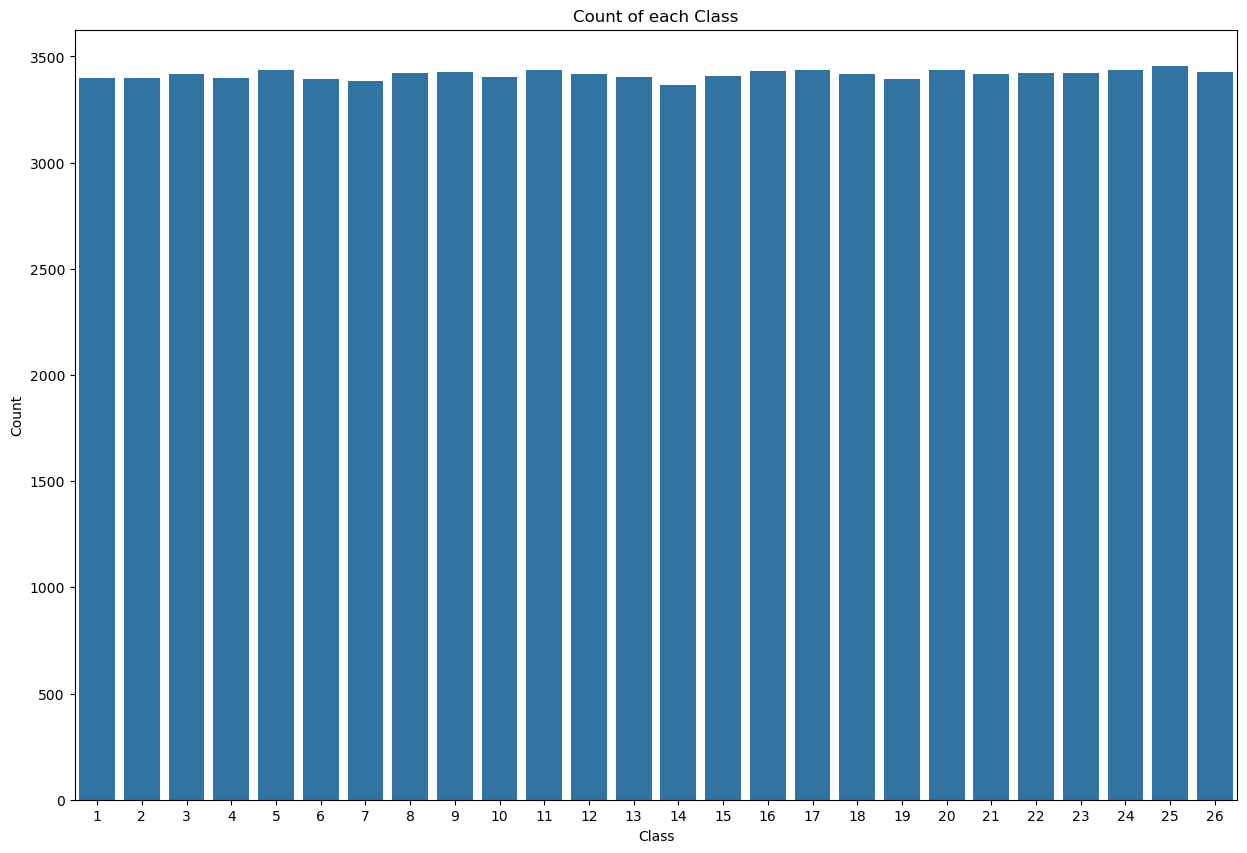

In [11]:
plt.figure(figsize=(15, 10))
sns.barplot(x=labels_counts.index, y=labels_counts.values)
plt.title("Count of each Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [12]:
for i, count in enumerate(labels_counts):
    print(f"Class {chr(i+65)}: {count}")

Class A: 3396
Class B: 3396
Class C: 3419
Class D: 3398
Class E: 3437
Class F: 3394
Class G: 3385
Class H: 3424
Class I: 3428
Class J: 3402
Class K: 3438
Class L: 3415
Class M: 3402
Class N: 3365
Class O: 3408
Class P: 3430
Class Q: 3435
Class R: 3419
Class S: 3392
Class T: 3436
Class U: 3419
Class V: 3422
Class W: 3423
Class X: 3437
Class Y: 3453
Class Z: 3427


In [13]:
labels = to_categorical(labels)
print(labels[0])
print("Label:", tf.argmax(labels[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0.]
Label: tf.Tensor(23, shape=(), dtype=int64)


In [14]:
imgs_final = imgs_final/255

In [16]:
preprocessing_v1 = Normalization()
preprocessing_v1.adapt(imgs_final)
imgs_final = preprocessing_v1(imgs_final)

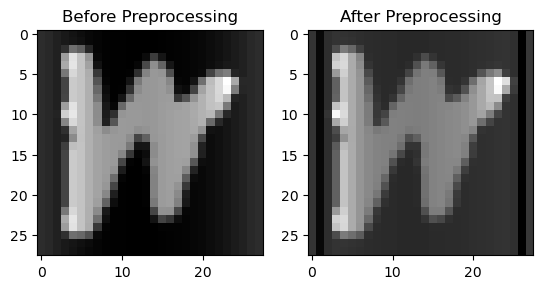

In [17]:
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(imgs_final[0], cmap="gray")
ax[0].set_title('Before Preprocessing')
ax[1].imshow(tf.squeeze(preprocessing_v1(imgs_final[:1, :, :])), cmap="gray")
ax[1].set_title('After Preprocessing')
plt.show()

In [18]:
imgs_final = np.expand_dims(imgs_final, axis=3)

In [169]:
class UCGAN():

    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((7, 7, 128)))
        # upsample to 14x14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # generate
        model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    # define the standalone discriminator model
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        # downsample
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        # downsample
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # classifier
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        lr_opt = Adam(learning_rate=0.001, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = True
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)

    def train(self, epochs, batch_size=128, save_interval=50):
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, imgs_final.shape[0], batch_size)
            imgs = imgs_final[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake= self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist_ucgan', exist_ok=True)
        fig.savefig("generated_mnist_ucgan/ucgan_mnist_{:d}.png".format(epoch))
        plt.close()

In [170]:
ucgan = UCGAN(28,28,1)
ucgan.train(epochs=5001, batch_size=256, save_interval=100)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_4 (Dropout)         (None, 6272)              0         
                                                                 
 dense_7 (Dense)             (None, 1)               

In [193]:
class CGAN:
    def __init__(self, rows, cols, channels, z=100):
        self.rows = rows
        self.cols = cols
        self.channels = channels
        self.z = z
        self.img_shape = (self.rows, self.cols, self.channels)
        self.latent_dim = z

        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):
        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def train(self, epochs, batch_size=128, save_interval=50):
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, imgs_final.shape[0], batch_size)
            imgs = imgs_final[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake= self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist_cgan', exist_ok=True)
        fig.savefig("generated_mnist_cgan/cgan_mnist_{:d}.png".format(epoch))
        plt.close()

In [194]:
cgan = CGAN(28,28,1)
cgan.train(epochs=5001, batch_size=256, save_interval=100)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_31 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_13 (Dropout)        (None, 256)              

In [20]:
class ACGAN():

    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.82))
        model.add(UpSampling2D())
    
        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(BatchNormalization(momentum=0.82))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
    
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(BatchNormalization(momentum=0.82))
        model.add(Activation("relu"))
        
        model.add(Conv2D(1, (3,3), padding='same'))
        model.add(Activation("tanh"))

        model.summary()
    
        # Generating the output image
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    # define the standalone discriminator model
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        # Building the input layer 
        model.add(Conv2D(16, (3,3), strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
    
        model.add(Conv2D(32, (3,3), strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
    
        model.add(BatchNormalization(momentum=0.8))
    
        model.add(Conv2D(64, (3,3), strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
    
        model.add(BatchNormalization(momentum=0.8))
    
        model.add(Conv2D(128, (3,3), strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
    
        model.add(Flatten())

        model.summary()
    
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        lr_opt = Adam(learning_rate=0.001, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = True
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)

    def train(self, epochs, batch_size=128, save_interval=50):
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, imgs_final.shape[0], batch_size)
            imgs = imgs_final[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake= self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist_acgan', exist_ok=True)
        fig.savefig("generated_mnist_acgan/acgan_mnist_{:d}.png".format(epoch))
        plt.close()

In [21]:
acgan = ACGAN(28,28,1)
acgan.train(epochs=5001, batch_size=256, save_interval=100)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 16)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 zero_padding2d (ZeroPadding  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                     